In [2]:
import pandas as pd
import numpy as np

In [10]:
# load data of 39 buildings
df = pd.read_csv('./USD_CNY历史数据-2.csv')
building_names = df.columns[1:]
load = []
for name in building_names:
    load.append(df[name].values)
load = np.array(load)

# choose one building
data_nor = load[0][::-1] 

# use max-min normalizaion
# maxval = np.max(data_ori)
# minval = np.min(data_ori)
# data_nor = list(map(lambda x: (x - minval) / (maxval - minval), data_ori))

In [11]:
# parameters:
ifs = 1000   # input feature size = 1
hfs = 30  # hidden feature size = 10
pfs = 365   # predict feature size = 1
mbs = 1

In [12]:
def multi_pred_navie_dataset(ratio=0.7):
    data_X = []
    data_Y = []
    
    for i in range(len(data_nor)-ifs-pfs):
        data_X.append(data_ori[i:i+ifs])
        data_Y.append(data_ori[i+ifs:i+ifs+pfs])
    
    train_size = int(len(data_X) * ratio)
    train_r = train_size - (train_size % mbs)
    
    test_size = len(data_X) - train_r
    test_r = test_size - (test_size % mbs) + train_r
        
    train_X = data_X[: train_r]
    train_Y = data_Y[: train_r]
    test_X = data_X[train_r : test_r]
    test_Y = data_Y[train_r : test_r]
    
    return [
        np.array(train_X).astype(np.float32),
        np.array(train_Y).astype(np.float32),
        np.array(test_X).astype(np.float32), 
        np.array(test_Y).astype(np.float32)
    ]

In [13]:
[train_X, train_Y, test_X, test_Y] = multi_pred_navie_dataset(0.2)
train_X.shape, train_Y.shape

((355, 1000), (355, 365))

In [14]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

In [15]:
class lstm(nn.Module):
    def __init__(self, input_size=24, hidden_size=30, output_size=24, num_layer=1):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        c0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [16]:
[train_X, train_Y, test_X, test_Y] = multi_pred_navie_dataset(0.2)

In [17]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

In [18]:
class lstm(nn.Module):
    def __init__(self, input_size=1000, hidden_size=30, output_size=365, num_layer=1):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        c0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [19]:
model = lstm().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [20]:
train_x = torch.from_numpy(train_X).view(-1, mbs, ifs).cuda()
train_y = torch.from_numpy(train_Y).view(-1, mbs,pfs).cuda()
test_x = torch.from_numpy(test_X).view(-1, mbs, ifs).cuda()
test_y = torch.from_numpy(test_Y).view(-1, mbs, pfs).cuda()

In [21]:
%%time
for e in range(800):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    
    out = model(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if (e + 1) % 50 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 50, Loss: 2.73708
Epoch: 100, Loss: 0.01502
Epoch: 150, Loss: 0.00837
Epoch: 200, Loss: 0.00830
Epoch: 250, Loss: 0.00830
Epoch: 300, Loss: 0.00830
Epoch: 350, Loss: 0.00830
Epoch: 400, Loss: 0.00830
Epoch: 450, Loss: 0.00830
Epoch: 500, Loss: 0.00830
Epoch: 550, Loss: 0.00830
Epoch: 600, Loss: 0.00829
Epoch: 650, Loss: 0.00829
Epoch: 700, Loss: 0.00829
Epoch: 750, Loss: 0.00829
Epoch: 800, Loss: 0.00829
CPU times: user 7.33 s, sys: 46.9 ms, total: 7.38 s
Wall time: 7.36 s


In [22]:
import matplotlib.pyplot as plt

In [44]:
model = model.eval()
pred_tensor = model(test_x)
pred_tensor.shape

torch.Size([1424, 1, 365])

In [48]:
pred_newest = pred_tensor[1423]
pred_newest.shape

torch.Size([1, 365])

In [50]:
pred_newest

tensor([[6.1869, 6.1861, 6.1852, 6.1845, 6.1834, 6.1827, 6.1819, 6.1810, 6.1801,
         6.1793, 6.1783, 6.1777, 6.1768, 6.1761, 6.1750, 6.1742, 6.1734, 6.1726,
         6.1717, 6.1708, 6.1701, 6.1694, 6.1686, 6.1679, 6.1670, 6.1663, 6.1656,
         6.1650, 6.1644, 6.1637, 6.1629, 6.1622, 6.1616, 6.1609, 6.1603, 6.1599,
         6.1591, 6.1586, 6.1578, 6.1573, 6.1567, 6.1563, 6.1557, 6.1553, 6.1548,
         6.1544, 6.1541, 6.1538, 6.1537, 6.1531, 6.1528, 6.1525, 6.1523, 6.1520,
         6.1515, 6.1515, 6.1509, 6.1508, 6.1507, 6.1505, 6.1503, 6.1503, 6.1502,
         6.1501, 6.1501, 6.1499, 6.1498, 6.1499, 6.1499, 6.1496, 6.1497, 6.1497,
         6.1496, 6.1496, 6.1495, 6.1493, 6.1493, 6.1494, 6.1493, 6.1493, 6.1493,
         6.1494, 6.1493, 6.1492, 6.1492, 6.1490, 6.1491, 6.1492, 6.1492, 6.1493,
         6.1494, 6.1496, 6.1496, 6.1497, 6.1495, 6.1494, 6.1496, 6.1496, 6.1495,
         6.1496, 6.1497, 6.1495, 6.1497, 6.1495, 6.1496, 6.1497, 6.1497, 6.1497,
         6.1498, 6.1499, 6.1

In [61]:
pred_tensor_p = pred_newest[0].cpu().detach().numpy()
fileout = pd.DataFrame(data=pred_tensor_p)
fileout.to_csv("out.csv")

In [38]:
pred_p = np.array(pred_tensor_p).reshape(-1)
pred_p.shape

(133225,)

In [39]:
test_y = torch.from_numpy(test_Y).view(-1, mbs, pfs).cuda()
test_y_p = [test_y[i].cpu().detach().numpy() for i in range(365)]

In [41]:
real_p = np.array(test_y_p).reshape(-1)
real_p.shape

(133225,)

In [35]:
diff = []
for i in range(364):
    diff.append((real_p[i] - pred_p[i])**2)
print(sum(diff) / len(diff))

[[0.00729416 0.00722716 0.00701714 0.00734658 0.00686804 0.00714543
  0.00718439 0.00725807 0.00698497 0.00710954 0.00695031 0.00733246
  0.00712837 0.00747232 0.00707078 0.00709731 0.0072021  0.00726989
  0.00700724 0.00682982 0.00695054 0.00722532 0.00704058 0.00727871
  0.00699838 0.0069391  0.00691413 0.0072174  0.00753926 0.00757126
  0.00717528 0.0072602  0.00729644 0.00715244 0.00719683 0.00773632
  0.00740555 0.0075743  0.00741833 0.00753303 0.00771111 0.0078888
  0.00764088 0.00805966 0.00778869 0.00773773 0.00770339 0.00782616
  0.00819968 0.00763354 0.00779109 0.00774995 0.00814003 0.00813757
  0.00777432 0.00830622 0.00773368 0.00797661 0.00831412 0.00801441
  0.00801816 0.00811295 0.00801528 0.00786056 0.0080646  0.00768739
  0.00776476 0.00802218 0.00813369 0.00765847 0.00805421 0.00810449
  0.00814495 0.0080802  0.00810235 0.0078843  0.00800483 0.00820242
  0.00809829 0.00810542 0.00805796 0.00832197 0.008138   0.00808374
  0.00825085 0.00787699 0.00804628 0.00807192 0.0

In [36]:
real_p

array([6.0747, 6.0686, 6.0617, ..., 6.6716, 6.7074, 6.722 ], dtype=float32)

ValueError: x and y can be no greater than 2-D, but have shapes (365,) and (365, 1, 365)

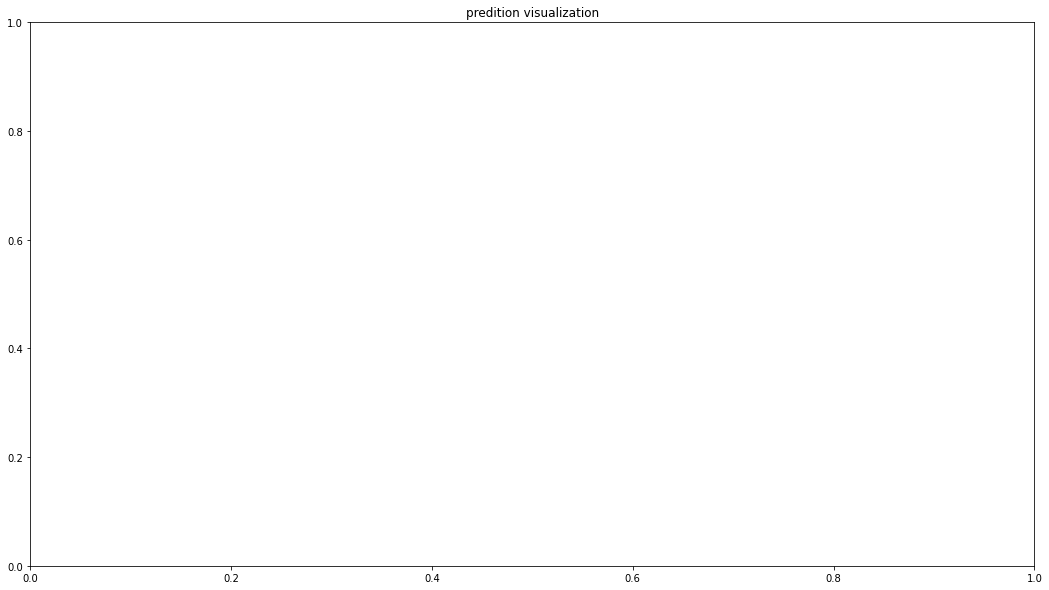

In [37]:
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(pred_p, 'r', label='prediction')
plt.plot(real_p, 'b', label='real')
plt.legend(loc='best')

In [ ]:
p = pred_p.reshape(-1, 24)
r = real_p.reshape(-1, 24)

In [ ]:
psum, rsum, pmax, rmax, pmin, rmin = [], [], [], [], [], []

for i in range(p.shape[0]):
    psum.append(sum(p[i]))
    rsum.append(sum(r[i]))
    
    pmax.append(max(p[i]))
    rmax.append(max(r[i]))
    
    pmin.append(min(p[i]))
    rmin.append(min(r[i]))

In [ ]:
plt.figure(figsize=(18, 10))
plt.title('psum & rsum')
plt.plot(psum, 'r', label='pred')
plt.plot(rsum, 'b', label='real')
plt.legend(loc='best')

In [ ]:
plt.figure(figsize=(18, 10))
plt.title('pmax & rmax')
plt.plot(pmax, 'r', label='pred')
plt.plot(rmax, 'b', label='real')
plt.legend(loc='best')

In [ ]:
plt.figure(figsize=(18, 10))
plt.title('pmin & rmin')
plt.plot(pmin, 'r', label='pred')
plt.plot(rmin, 'b', label='real')
plt.legend(loc='best')

In [ ]:
sumdiff = 0
for i in range(len(psum)):
    sumdiff += (psum[i] - rsum[i]) ** 2
    
sumdiff / len(psum)

In [ ]:
maxdiff = 0
for i in range(len(pmax)):
    maxdiff += (pmax[i] - rmax[i]) ** 2
    
maxdiff / len(pmax)

In [ ]:
mindiff = 0
for i in range(len(pmax)):
    mindiff += (pmin[i] - rmin[i]) ** 2
    
mindiff / len(pmin)